In [1]:
import numpy as np
import control as ct
import matplotlib.pyplot as plt

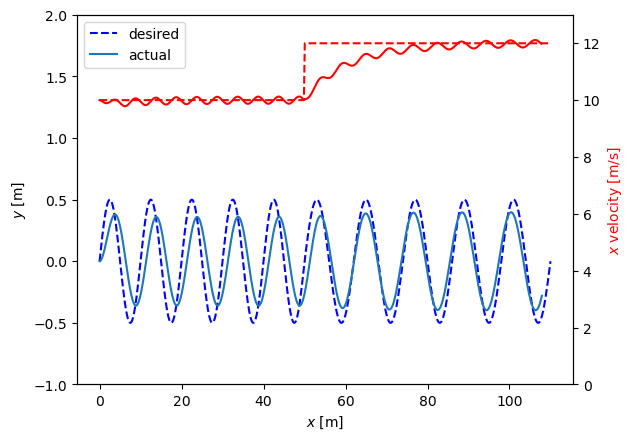

In [ ]:
def vehicle_update(t, x, u, params):
    # Get the parameters for the model
    a = params.get('refoffset', 1.5)        # offset to vehicle reference point
    b = params.get('wheelbase', 3.)         # vehicle wheelbase
    maxsteer = params.get('maxsteer', np.deg2rad(30))  # max steering angle (rad)

    # Saturate the steering input
    delta = np.clip(u[1], -maxsteer, maxsteer)
    alpha = np.arctan2(a * np.tan(delta), b)

    # Return the derivative of the state
    return np.array([
        u[0] * np.cos(x[2] + alpha),    # xdot = cos(theta + alpha) v
        u[0] * np.sin(x[2] + alpha),    # ydot = sin(theta + alpha) v
        (u[0] / a) * np.sin(alpha)      # thdot = v sin(alpha) / a
    ])

# Define the readout map for the system, h(x, u)
# Outputs: x, y (planar position of the center of mass)
def vehicle_output(t, x, u, params):
    return x

# Default vehicle parameters (including nominal velocity)
vehicle_params={'refoffset': 1.5, 'wheelbase': 3, 'velocity': 15,
                'maxsteer': np.deg2rad(30)}

# Define the vehicle steering dynamics as an input/output system
vehicle = ct.nlsys(
    vehicle_update, vehicle_output, states=3, name='vehicle',
    inputs=['v', 'delta'], outputs=['x', 'y', 'theta'], params=vehicle_params)
# Define the time interval that we want to use for the simualation
timepts = np.linspace(0, 10, 1000)
# Create the desired trajectory
Ud = np.array([10 * np.ones_like(timepts), np.zeros_like(timepts)])
Xd = np.array([10 * timepts, 0 * timepts, np.zeros_like(timepts)])

# Now linizearize the system around this trajectory
linsys = vehicle.linearize(Xd[:, 0], Ud[:, 0])
# Compute LQR controller
K, S, E = ct.lqr(linsys, np.diag([1, 1, 1]), np.diag([1, 1]))
def control_output(t, x, z, params):
    # Get the parameters for the model
    K = params.get('K', np.zeros((2, 3)))   # nominal gain

    # Split up the input to the controller into the desired state and nominal input
    xd_vec = z[0:3]    # desired state ('xd', 'yd', 'thetad')
    ud_vec = z[3:5]    # nominal input ('vd', 'deltad')
    x_vec = z[5:8]     # current state ('x', 'y', 'theta')

    # Compute the control law
    return ud_vec - K @ (x_vec - xd_vec)

# Define the controller system
control = ct.nlsys(
    None, control_output, name='control',
    inputs=['xd', 'yd', 'thetad', 'vd', 'deltad', 'x', 'y', 'theta'],
    outputs=['v', 'delta'], params={'K': K})
# Build the closed loop system
vehicle_closed = ct.interconnect(
    (vehicle, control),
    inputs=['xd', 'yd', 'thetad', 'vd', 'deltad'],
    outputs=['x', 'y', 'theta']
)
Xd = np.array([
    10 * timepts + 2 * (timepts-5) * (timepts > 5),
    0.5 * np.sin(timepts * 2*np.pi),
    np.zeros_like(timepts)
])

Ud = np.array([10 * np.ones_like(timepts), np.zeros_like(timepts)])

# Simulate the system dynamics, starting from the origin
resp = ct.input_output_response(
    vehicle_closed, timepts, np.vstack((Xd, Ud)), 0)
time, outputs = resp.time, resp.outputs
# Plot the results in the xy plane
plt.plot(Xd[0], Xd[1], 'b--')      # desired trajectory
plt.plot(outputs[0], outputs[1])   # actual trajectory
plt.xlabel("$x$ [m]")
plt.ylabel("$y$ [m]")
plt.ylim(-1, 2)

# Add a legend
plt.legend(['desired', 'actual'], loc='upper left')

# Compute and plot the velocity
rightax = plt.twinx()       # Create an axis in the right
rightax.plot(Xd[0, :-1], np.diff(Xd[0]) / np.diff(timepts), 'r--')
rightax.plot(outputs[0, :-1], np.diff(outputs[0]) / np.diff(timepts), 'r-')
rightax.set_ylim(0, 13)
rightax.set_ylabel("$x$ velocity [m/s]")
rightax.yaxis.label.set_color('red')